<a href="https://colab.research.google.com/github/Bharathkrishnamurthy/21Day_21_ML-_project/blob/main/DAY10_Generating_art.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project 10 : CREATIVE AI GENERATES ARTS

1.Import Necessasry Library

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kushsheth/face-vae")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'face-vae' dataset.
Path to dataset files: /kaggle/input/face-vae


In [ ]:
# import necessary library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras import layers
import time
from tqdm import tqdm_gui
# Put this in the top cell of the notebook (one-liner)
%matplotlib inline


IMAGE_SHAPE=(128,128,3)
BATCH_SIZE=128
NOISE_DIM=100
EPOCHS=50
DATA_DIR=path

def preprocess_image(path):
    img_raw=tf.io.read_file(path)
    img=tf.image.decode_jpeg(img_raw,channels=3)
    img=tf.image.resize(img,[128,128])
    img=(img/127.5) - 1.0
    return img

def load_celeba_images(path):
    all_files=tf.io.gfile.glob(os.path.join(path,"*.jpg"))
    dataset=tf.data.Dataset.from_tensor_slices(all_files)
    dataset=dataset.map(preprocess_images,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset=dataset.batch(BATCH_SIZE)

    images_list=[]
    for batch in tqdm(dataset.batch(1024).prefetch(tf.data.experimental.AUTOTUNE)):
        images_list.append(batch)

    images=tf.concat(images_list,axis=0)
    dataset=tf.data.Dataset.from_tensor_slices(images)\
    .shuffle(buffer_size=1024)\
    .batch(BATCH_SIZE,drop_remainder=True)\
    .prefetch(tf.data.experimental.AUTOTUNE)

    return dataset



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def build_generator(NOISE_DIM=NOISE_DIM):
    model = tf.keras.Sequential([
        # 1) Start with a dense layer that reshapes to 8x8 with 512 channels
        layers.Dense(8*8*512, use_bias=False, input_shape=(NOISE_DIM,)),
        layers.Reshape((8, 8, 512)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # 2) Upsample to 16x16
        layers.Conv2DTranspose(256, (4,4), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # 3) Upsample to 32x32
        layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # 4) Upsample to 64x64
        layers.Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # 5) Upsample to 128x128
        layers.Conv2DTranspose(32, (4,4), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # 6) Final layer → 128x128x3, use tanh for output in [-1,1]
        layers.Conv2DTranspose(3, (4,4), strides=(1,1), padding='same', use_bias=False, activation='tanh')
    ], name="Generator")

    return model


def build_discriminator():
    model = tf.keras.Sequential([
        # 1) Downsample from 128x128 to 64x64
        layers.Conv2D(64, (4,4), strides=(2,2), padding='same',
                      input_shape=(128,128,3)),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        # 2) Downsample to 32x32
        layers.Conv2D(128, (4,4), strides=(2,2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        # 3) Downsample to 16x16
        layers.Conv2D(256, (4,4), strides=(2,2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        # 4) Downsample to 8x8
        layers.Conv2D(512, (4,4), strides=(2,2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        # 5) Flatten to a single logit
        layers.Flatten(),
        layers.Dense(1)
    ], name="Discriminator")

    return model

In [ ]:
generator = build_generator()
discriminator = build_discriminator()


cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

gen_optimizer = tf.keras.optimizers.Adam(1e-4)
disc_optimizer = tf.keras.optimizers.Adam(1e-4)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt

def generate_and_show_images(generator, noise, epoch=None):
    # generator: Keras model, noise: tf.Tensor or np.array
    preds = generator(noise, training=False)
    # Ensure numpy
    preds = preds.numpy() if hasattr(preds, "numpy") else np.array(preds)
    # Scale from [-1,1] -> [0,1]
    preds = (preds + 1.0) / 2.0
    preds = np.clip(preds, 0.0, 1.0)

    # grid size
    n = preds.shape[0]
    rows = int(np.sqrt(n))
    cols = rows if rows * rows == n else (rows + 1)

    # clear previous output so notebook shows only latest
    clear_output(wait=True)

    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    axes = np.array(axes).reshape(-1)
    for i in range(rows * cols):
        ax = axes[i]
        ax.axis('off')
        if i < n:
            ax.imshow(preds[i])
    if epoch is not None:
        plt.suptitle(f"Epoch {epoch}")
    plt.tight_layout()
    plt.show()


In [ ]:
def train(dataset, epochs):
    fixed_noise = tf.random.normal([16, NOISE_DIM])  # Fixed noise for generating sample images
    total_start_time = time.time()  # Start time for total training

    for epoch in range(epochs):
        epoch_start_time = time.time()  # Start time for the current epoch

        g_losses = []
        d_losses = []

        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)
            g_losses.append(g_loss)
            d_losses.append(d_loss)

        # Calculate average losses for the epoch
        avg_g_loss = tf.reduce_mean(g_losses)
        avg_d_loss = tf.reduce_mean(d_losses)

        # Time taken for the epoch
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time

        # Print epoch details
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Generator loss: {avg_g_loss:.4f}, "
              f"Discriminator loss: {avg_d_loss:.4f} | "
              f"Time: {epoch_duration:.2f} seconds")

        # Generate and show images for the current epoch
        # inside train loop, replace generate_and_show_images(fixed_noise)
        generate_and_show_images(generator, fixed_noise, epoch=epoch+1)
        # quick manual check
        sample_noise = tf.random.normal([16, NOISE_DIM])
        generate_and_show_images(generator, sample_noise, epoch=0)



    # Total time taken for training
    total_end_time = time.time()
    total_duration = total_end_time - total_start_time
    print(f"\nTotal Training Time: {total_duration:.2f} seconds")

    # display images
    generate_and_show_images(generator, fixed_noise)
    # print images
    generate_and_show_images(generator, sample_noise)

In [ ]:
print("Path to dataset files:", path)

import os, glob

# Check what files exist in the dataset path
print("Checking dataset structure:")
for root, dirs, files in os.walk(path):
    print(root, "->", len(files), "files")

# If no JPGs found, maybe they are inside a subfolder
jpg_files = glob.glob(os.path.join(path, "**", "*.jpg"), recursive=True)
print(f"Total JPG files found: {len(jpg_files)}")

if not jpg_files:
    raise ValueError(f"No .jpg files found even in subdirectories of {path}")
else:
    print("✅ Sample file:", jpg_files[0])



Path to dataset files: /kaggle/input/face-vae
Checking dataset structure:
/kaggle/input/face-vae -> 4 files
/kaggle/input/face-vae/img_align_celeba -> 0 files
/kaggle/input/face-vae/img_align_celeba/img_align_celeba -> 202599 files
Total JPG files found: 202599
✅ Sample file: /kaggle/input/face-vae/img_align_celeba/img_align_celeba/083648.jpg


In [ ]:
import tensorflow as tf
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

with strategy.scope():
    generator = build_generator()
    discriminator = build_discriminator()

    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    def generator_loss(fake_output):
        return cross_entropy(tf.ones_like(fake_output), fake_output)

    def discriminator_loss(real_output, fake_output):
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        return real_loss + fake_loss

    gen_optimizer = tf.keras.optimizers.Adam(1e-4)
    disc_optimizer = tf.keras.optimizers.Adam(1e-4)

# Existing dataset creation
# dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(10000).batch(BATCH_SIZE)
# Minimal fix: create dataset from image file paths in DATA_DIR
all_files = tf.io.gfile.glob(os.path.join(DATA_DIR))

if not all_files:
    raise ValueError(f"No .jpg files found in {DATA_DIR}")

dataset = tf.data.Dataset.from_tensor_slices(all_files)
dataset = dataset.shuffle(10000)
dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)



# Make a distributed dataset
dist_dataset = strategy.experimental_distribute_dataset(dataset)

@tf.function

def distributed_train_step(dataset_inputs):
    def step_fn(real_images):
        return train_step(real_images)  # The train_step you already have

    per_replica_g_loss, per_replica_d_loss = strategy.run(step_fn, args=(dataset_inputs,))
    mean_g_loss = strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_g_loss, axis=None)
    mean_d_loss = strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_d_loss, axis=None)
    return mean_g_loss, mean_d_loss


def train(dataset, epochs):
    fixed_noise = tf.random.normal([16, NOISE_DIM])
    total_start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()

        g_losses = []
        d_losses = []

        for image_batch in dist_dataset:  # Use distributed dataset
            g_loss, d_loss = distributed_train_step(image_batch)
            g_losses.append(g_loss)
            d_losses.append(d_loss)

        avg_g_loss = tf.reduce_mean(g_losses)
        avg_d_loss = tf.reduce_mean(d_losses)

        epoch_duration = time.time() - epoch_start_time
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Generator loss: {avg_g_loss:.4f}, "
              f"Discriminator loss: {avg_d_loss:.4f} | "
              f"Time: {epoch_duration:.2f} s")

        generate_and_show_images(fixed_noise)

    total_duration = time.time() - total_start_time
    print(f"\nTotal Training Time: {total_duration:.2f} seconds")

    # PRINT IMAGES
    generate_and_show_images(fixed_noise)



## Assignment: Oxford Flowers 102 Image Generator using GANs

Based on the provided code for training a GAN, your assignment is to build a GAN to generate realistic flower images using the Oxford Flowers 102 dataset.

**Task:**

1.  **Data Loading and Preprocessing:**
    *   Ensure the code correctly loads and preprocesses the Oxford Flowers 102 dataset using `tensorflow_datasets`, resizing images to the desired `IMAGE_SHAPE` and normalizing pixel values to [-1, 1]. The current code in cell `cINCGsobBYzc` should handle this.

2.  **Generator Architecture:**
    *   Review and potentially modify the `build_generator` function to ensure it is suitable for generating flower images. The current architecture is designed for 128x128 images and should be a good starting point. The input will be a noise vector.

3.  **Discriminator Architecture:**
    *   Review and potentially modify the `build_discriminator` function. The current architecture is designed for 128x128 images and should also be a good starting point. Its role is to distinguish between real flower images from the dataset and fake flower images generated by the generator.

4.  **Loss Functions and Optimizers:**
    *   Ensure the `generator_loss` and `discriminator_loss` functions, and the optimizers (`gen_optimizer`, `disc_optimizer`) are correctly defined for the GAN training process. The current setup in cell `kQEmbCt7BYzd` and `lVYSVXRnBYze` should be appropriate.

5.  **Training:**
    *   Use the provided `train_step` and `train` functions (potentially using the distributed training setup) to train the GAN on the preprocessed Oxford Flowers 102 dataset.

6.  **Evaluation and Visualization:**
    *   Utilize the `generate_and_show_images` function to visualize the progress of the generator during training by generating sample flower images from a fixed noise vector.
    *   After training, visually evaluate the quality and diversity of the generated flower images.

**Deliverables:**

*   The modified Python notebook with the working code for the flower image generator.
*   A brief report (can be a markdown section in the notebook) describing:
    *   Any significant modifications made to the generator or discriminator architectures.
    *   Observations during training (e.g., convergence, quality of generated images over epochs).
    *   Examples of generated flower images after training.
    *   Any challenges encountered during the process.

**Tips:**

*   Ensure the data preprocessing correctly scales and normalizes the image data.
*   Monitor the generator and discriminator losses during training to understand the GAN's progress.
*   Experiment with the number of epochs to find a good balance between training time and generated image quality.
*   Adjust hyperparameters like learning rates if needed.

In [ ]:
import tensorflow_datasets as tfds

# Load the Oxford Flowers 102 dataset
try:
    dataset, info = tfds.load('oxford_flowers102:2.1.1', with_info=True, as_supervised=True)

    # Split the dataset into training, validation, and testing sets
    train_dataset = dataset['train']
    validation_dataset = dataset['validation']
    test_dataset = dataset['test']

    # Print information about the dataset
    print(info)

except Exception as e:
    print(f"Error loading dataset: {e}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.1PUZO9_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.1PUZO9_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.1PUZO9_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see

2. Importing lib And Data Preprocessing

In [ ]:
# cell: imports + constants + TFDS loading
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

# Settings
IMAGE_SHAPE = (128, 128, 3)
BATCH_SIZE = 128         # change if you need; if using multiple GPUs ensure divisibility
NOISE_DIM = 100
EPOCHS = 30              # you can change this
BUFFER_SIZE = 10000

# 1. Load Oxford Flowers 102
ds, info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)
train_ds = ds['train']
val_ds = ds['validation']
test_ds = ds['test']

print("Dataset info:\n", info)


Dataset info:
 tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/d

3. PRE-Process DATA_PIPELINE


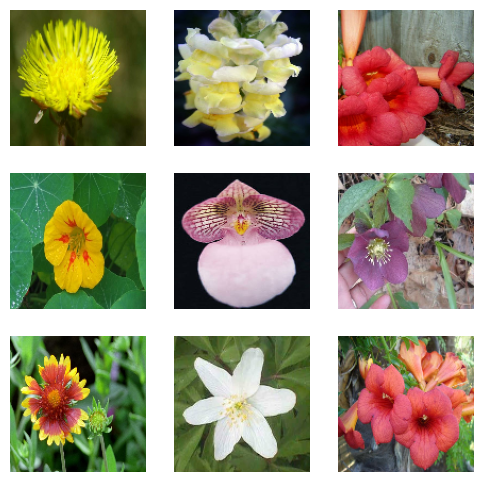

In [ ]:
# cell: preprocess + dataset pipeline
def preprocess_image_tf(image, label=None):
    # image: uint8 HxWxC
    image = tf.image.resize(image, IMAGE_SHAPE[:2])
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1.0   # normalize to [-1,1]
    return image  # we only need images for GAN

def make_dataset(tfds_dataset, batch_size=BATCH_SIZE, shuffle=True):
    ds = tfds_dataset.map(lambda im, lbl: preprocess_image_tf(im), num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(BUFFER_SIZE)
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = make_dataset(train_ds)
val_dataset = make_dataset(val_ds, shuffle=False)
test_dataset = make_dataset(test_ds, shuffle=False)

# Quick check: show a few real images from the dataset
for batch in train_dataset.take(1):
    sample = batch[:9].numpy()
    sample = (sample + 1.0) / 2.0
    fig, axes = plt.subplots(3,3, figsize=(6,6))
    axes = axes.flatten()
    for i in range(9):
        axes[i].imshow(sample[i])
        axes[i].axis('off')
    plt.show()


4. Generator And Discreminator

In [ ]:
# cell: generator & discriminator
def build_generator(noise_dim=NOISE_DIM):
    model = tf.keras.Sequential(name="Generator")
    model.add(layers.Dense(8*8*512, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.Reshape((8, 8, 512)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256, (4,4), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (4,4), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (4,4), strides=(1,1), padding='same', use_bias=False, activation='tanh'))
    return model

def build_discriminator():
    model = tf.keras.Sequential(name="Discriminator")
    model.add(layers.Conv2D(64, (4,4), strides=(2,2), padding='same', input_shape=IMAGE_SHAPE))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

# Instantiate
generator = build_generator()
discriminator = build_discriminator()

# Quick shapes check
print("Generator output shape:", generator(tf.random.normal([1, NOISE_DIM])).shape)
print("Discriminator output shape:", discriminator(tf.random.normal([1, *IMAGE_SHAPE])).shape)


Generator output shape: (1, 128, 128, 3)
Discriminator output shape: (1, 1)


5. LOSSES and Optimization

In [ ]:
# cell: losses, optimizers, train step, and viz helper
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

gen_optimizer = tf.keras.optimizers.Adam(1e-4)
disc_optimizer = tf.keras.optimizers.Adam(1e-4)

# Use @tf.function for speed
@tf.function
def train_step(real_images):
    # dynamic batch size
    batch_size = tf.shape(real_images)[0]
    noise = tf.random.normal([batch_size, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        g_loss = generator_loss(fake_output)
        d_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(d_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return g_loss, d_loss

# visualization helper - robust for notebooks
def generate_and_show_images(generator, noise, epoch=None):
    preds = generator(noise, training=False)
    preds = preds.numpy() if hasattr(preds, "numpy") else np.array(preds)
    preds = (preds + 1.0) / 2.0
    preds = np.clip(preds, 0.0, 1.0)

    n = preds.shape[0]
    rows = int(np.sqrt(n))
    cols = rows if rows*rows == n else rows+1
    clear_output(wait=True)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    axes = np.array(axes).reshape(-1)
    for i in range(rows*cols):
        axes[i].axis('off')
        if i < n:
            axes[i].imshow(preds[i])
    if epoch is not None:
        plt.suptitle(f"Epoch {epoch}")
    plt.tight_layout()
    plt.show()


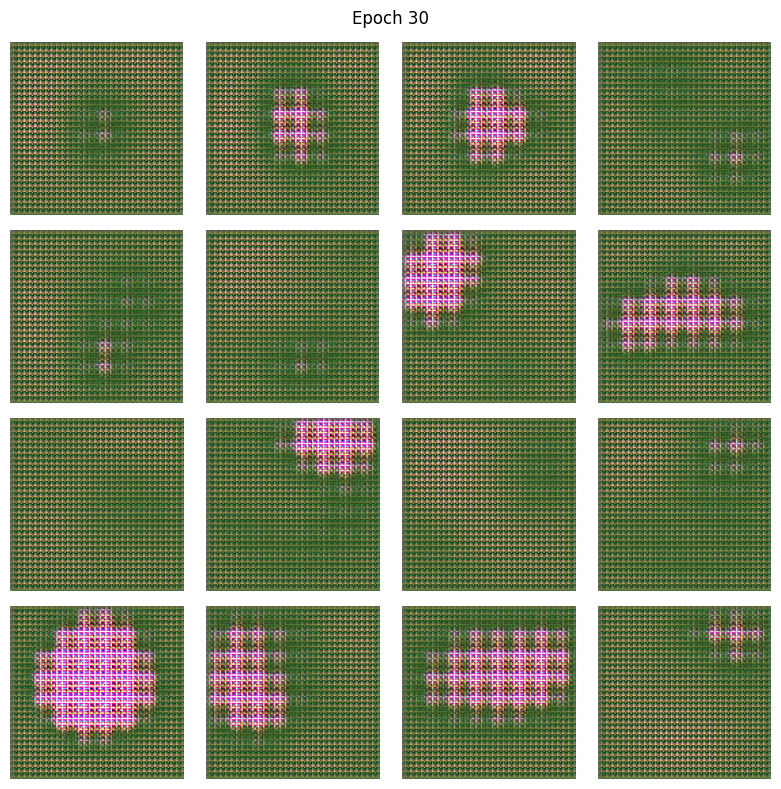

In [ ]:
# cell: training loop
fixed_noise = tf.random.normal([16, NOISE_DIM])  # fixed vector for monitoring
def train(dataset, epochs=EPOCHS):
    for epoch in range(epochs):
        start = time.time()
        g_losses = []
        d_losses = []
        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)
            g_losses.append(g_loss)
            d_losses.append(d_loss)

        avg_g = tf.reduce_mean(g_losses)
        avg_d = tf.reduce_mean(d_losses)
        epoch_time = time.time() - start
        print(f"Epoch {epoch+1}/{epochs} | G_loss: {avg_g:.4f} | D_loss: {avg_d:.4f} | Time: {epoch_time:.1f}s")
        generate_and_show_images(generator, fixed_noise, epoch=epoch+1)

# Train (call this to start training)
train(train_dataset, epochs=EPOCHS)


In [ ]:
# comparision of both the dataset evaluation metrics in graph

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))
plt.plot(g_losses, label='Generator Loss', linestyle='--', marker='o')
plt.plot(d_losses, label='Discriminator Loss', linestyle='-', marker='x')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()